# Forecast POC Guide

This notebook will walk you through the process of building a custom collection of models with Amazon Forecast based on the time series data you have for your problem.

## Overview

1. Introduction to Amazon Forecast
1. Obtaining Your Data
1. Fitting the Data to Forecast
1. Determining Your Forecast Horizon (1st pass)
1. Building Your First Few Predictors
1. Visualizing Predictors
1. Making Decisions
1. Adding Related Time Series Data
1. Evaluations Again
1. Next Steps


## Introduction to Amazon Forecast

If you are not familiar with Amazon Forecast you can learn more about this tool on these pages:

* Product Page: https://aws.amazon.com/forecast/
* GitHub Sample Notebooks: https://github.com/aws-samples/amazon-forecast-samples
* Product Docs: https://docs.aws.amazon.com/forecast/latest/dg/what-is-forecast.html


## Obtaining Your Data

A critical requirement to use Amazon Forecast is to have access to time-series data for your selected use case. To learn more about time series data:

1. Wikipedia: https://en.wikipedia.org/wiki/Time_series
1. Toward's Data Science Primer: https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775
1. O'Reilly Book: https://www.amazon.com/gp/product/1492041653/ref=ppx_yo_dt_b_search_asin_title?ie=UTF8&psc=1

As an exmaple for this POC guide we are going to select a dataset from the UCI repository of machine learning datasets. This is a great tool for finding datasets for various problems. In this particular case it is traffic data for a given section of interstate highway. More information on the dataset can be found here: https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

To begin the cell below when executed will create a data folder and download our dataset into it, lastly it will extract the data into a csv file we can edit locally.







In [3]:
!mkdir data
!cd data && wget https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz
!gunzip data/Metro_Interstate_Traffic_Volume.csv.gz

mkdir: cannot create directory ‘data’: File exists
--2019-12-24 19:58:58--  https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 405373 (396K) [application/x-httpd-php]
Saving to: ‘Metro_Interstate_Traffic_Volume.csv.gz’

Metro_Interstate_Tr 100%[===================>] 395.87K  1.41MB/s    in 0.3s    

2019-12-24 19:58:58 (1.41 MB/s) - ‘Metro_Interstate_Traffic_Volume.csv.gz’ saved [405373/405373]



With the data downloaded, now we will import the Pandas library as well as a few other data science tools in order to inspect the information.

In [14]:
import boto3
from time import sleep
import subprocess
import pandas as pd
import json
import time
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [5]:
original_data = pd.read_csv('data/Metro_Interstate_Traffic_Volume.csv')
original_data.head(5)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


At this point we can see a few things about the data:

* Holidays seem to be specified
* There is a value for temp but the units are unclear
* Look like a few weather measurements as well
* The time series itself is hourly
* There is a final column called traffic_volume that hopefully is impacted by these other fields.

Reducing the dataset to the things that are absolutely critical for Amazon Forecast would yield something like the following:

1. item_id = This would just be set to 0 or 1, or some arbitary ID. Amazon Forecast is designed to work with multiple time series, so we are just going to define a singular one here.
1. timestamp = The one provided should suffice. 
1. traffic_volume = The value here should suffice as well for us, and will be what we look to predict going forward.

The other attributes provided can serve as a basis for related time series components when we get to that much later.

To assist with the initial exploration of the data. First you will use the code below to reduce the dataframe to only the columns needed, then add the item_id column. Lastly we will plot the values over time to see what our series looks like.


In [6]:
target_df = original_data[['date_time', 'traffic_volume']]
target_df.columns = ['TIMESTAMP', 'TARGET_VALUE']
target_df.insert(0, 'ITEM_ID', '1')
target_df.head(5)

,ITEM_ID,TIMESTAMP,TARGET_VALUE
0,1,2012-10-02 09:00:00,5545
1,1,2012-10-02 10:00:00,4516
2,1,2012-10-02 11:00:00,4767
3,1,2012-10-02 12:00:00,5026
4,1,2012-10-02 13:00:00,4918


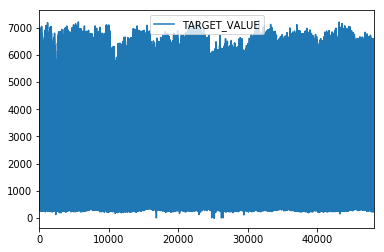

In [16]:
target_df.plot()

By default the plot we are seeing is not the most helpful, at present it is very hard to see what variations within the data exists, and when those may be altered by time. Given we have hourly data a quick check could be to pick a date range and inspect it to see how the value shifts over time.

#TODO:

* Set column for timestamp to timestampe type or datetime type at least.
* Print Date Range of Dataset
* Select a particluar day
* Render
* Do the same for a week, month, and year